# Low-Rank and Linear Spectral Matrix Completion for Playlist Recommendation

In [ ]:
# -*- coding: utf8 -*-
import sys
import os
import time
import operator
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy.sparse
import itertools
import random
import community
import IPython.utils.path
import cPickle as pickle 
from sklearn.cross_validation import train_test_split


%matplotlib inline
mpl.rcParams['axes.edgecolor'] = 'grey'
mpl.rcParams['grid.color'] = '#66CCCC'
mpl.rcParams['text.color'] = '#0EBFE9'
mpl.rcParams['xtick.color'] = '#66CCCC'
mpl.rcParams['ytick.color'] = '#66CCCC'
mpl.rcParams['axes.labelcolor'] = '#0EBFE9'

import recog 

%load_ext autoreload
%autoreload 2

# reload(sys)  # Reload does the trick!
# sys.setdefaultencoding('UTF8')

# pd.options.display.encoding = 'utf-8'

In [ ]:
import bokeh.plotting as bp
from bokeh.palettes import brewer
bp.output_notebook()

# Test on real data

In [ ]:
def plot_mat(x, title, fig=(512, 200), cmap='Greys', reverse=False, nb_colors=9):
    f1 = bp.figure(plot_width=fig[0], plot_height=fig[1], 
                   x_range=[0, x.shape[1]], y_range=[0, x.shape[0]])
    

    pal = brewer[cmap][nb_colors]
    if reverse:
        pal = pal[::-1]
        
    f1.image(image=[x], x=[0], y=[0], 
             dw=[x.shape[1]], dh=[x.shape[0]], palette=pal)
    f1.title = title
    f1.title_text_color = 'red'
    f1.title_text_font_style = 'bold'
    bp.show(f1)

In [ ]:
# DATA_DIR = os.path.join(IPython.utils.path.get_home_dir(), 'data/aotmv2/')
DATA_DIR = os.path.join( IPython.utils.path.get_home_dir(), 'local/aotmv2/')
print 'Data directory:', DATA_DIR

DATASET_NAME = 'aotm'
MAX_PROCESS = 8
song_id_key = 'aotm_id'
playlist_id_key = 'mix_id'
playlist_cat_key = 'playlist_category'

In [ ]:
FULL_SONGS = pd.read_hdf(os.path.join(DATA_DIR, DATASET_NAME + '_songs.h5'), 'data')
FULL_SONGS.rename(columns={'temporal_echonest_features': 'ten'}, inplace=True)
FULL_PLAYLISTS = pd.read_hdf(os.path.join(DATA_DIR, DATASET_NAME + '_playlists.h5'), 'data')
FULL_MIXES = pd.read_hdf(os.path.join(DATA_DIR, DATASET_NAME + '_mixes.h5'), 'data')

In [ ]:
# Extract features only from data
to_remove = set(['title', 'artist_name', 'genre', 'top_genres', 'terms', 
                 'release', 'key', 'mode', 'genre_topics', 'genre_topic', 'ncut_id'])
columns = set(FULL_SONGS.columns.tolist())
feat_col = list(columns - to_remove)

### Create smaller dataset from AOTM data

Here we remove ambiguous plyalist categories, we also verify that there are a sufficient number of playlists in each category. Each playlist is composed of "popular songs", (songs seen at least in a certain amount of playlists), and is not too short not too long.

In [ ]:
# min_playlists = 70
min_playlists = 100
# min_playlist_size = 8
min_playlist_size = 5
max_playlist_size = 20
min_popularity = 5

to_remove = ['Mixed Genre', 'Theme', 'Single Artist', 'Alternating DJ', 'Mixed', 'Cover', 'Narrative']

In [ ]:
# Remove ambiguous categories
FILT_MIXES = FULL_MIXES[~FULL_MIXES.playlist_category.isin(to_remove)]
# Remove too short or too long playlists
FILT_MIXES = FILT_MIXES[FILT_MIXES['size'].between(min_playlist_size, max_playlist_size)]

# Filter popular songs
good_playlist_categories = np.unique(FILT_MIXES.playlist_category.values)
FILT_PLAYLISTS = FULL_PLAYLISTS[FULL_PLAYLISTS[playlist_cat_key].isin(good_playlist_categories)]
song_popularity_hist = FILT_PLAYLISTS.aotm_id.value_counts()
good_songs = song_popularity_hist[song_popularity_hist >= min_popularity].index.values
FILT_MIXES[song_id_key] = FILT_MIXES[song_id_key].apply(lambda x: list((set(x) & set(good_songs))))
FILT_MIXES['size'] = FILT_MIXES[song_id_key].apply(len)

# Refilter size of playlists
FILT_MIXES = FILT_MIXES[FILT_MIXES['size'].between(min_playlist_size, max_playlist_size)]
# Keep a sufficient number of playlist in each category
p_hist = FILT_MIXES[playlist_cat_key].value_counts()
P_CATEGORIES = p_hist.index[np.where(p_hist > min_playlists)].values
FILT_MIXES = FILT_MIXES[FILT_MIXES[playlist_cat_key].isin(P_CATEGORIES)]

# Update the list of valid songs since we removed some playlists
good_songs = np.unique(list(itertools.chain(*list(FILT_MIXES[song_id_key].values))))
FILT_PLAYLISTS = FILT_PLAYLISTS[FILT_PLAYLISTS[playlist_id_key].isin(FILT_MIXES.index.values)]
FILT_PLAYLISTS = FILT_PLAYLISTS[FILT_PLAYLISTS[song_id_key].isin(good_songs)]

# Keep only valid song and features in playlists
FILT_SONGS = FULL_SONGS[FULL_SONGS.index.isin(good_songs)].sort('genre')
FILT_FEAT = FILT_SONGS[feat_col]

print 'Number of playlists:', len(FILT_MIXES)
print 'Number of songs:', len(FILT_SONGS)

In [ ]:
FILT_MIXES[playlist_cat_key].value_counts()

### Create evenly sampled dataset

In [ ]:
to_keep = ['Romantic', 'Depression', 'Break Up', 'Sleep',
           'Punk', 'Country', 'Hip Hop', 'Dance/House', 'Rock', 'Rhythm and Blues']

P_CATEGORIES = to_keep

cat_size = 100

In [ ]:
MINI_MIXES = FILT_MIXES[FILT_MIXES.playlist_category.isin(to_keep)]

tmp = MINI_MIXES.reset_index().groupby(playlist_cat_key).agg({playlist_id_key: lambda x: random.sample(x, cat_size)})
good_mixes = np.unique(list(itertools.chain(*list(tmp[playlist_id_key].values))))

MINI_MIXES = MINI_MIXES[MINI_MIXES.index.isin(good_mixes)]
# sample_idx = random.sample(MINI_MIXES.index, len(MINI_MIXES) // sample_factor)
# MINI_MIXES = MINI_MIXES[MINI_MIXES.index.isin(sample_idx)]
# Update the list of valid songs since we removed some playlists
good_songs = np.unique(list(itertools.chain(*list(MINI_MIXES[song_id_key].values))))
MINI_PLAYLISTS = FILT_PLAYLISTS[FILT_PLAYLISTS[playlist_id_key].isin(MINI_MIXES.index.values)]
MINI_PLAYLISTS = MINI_PLAYLISTS[MINI_PLAYLISTS[song_id_key].isin(good_songs)]

# Keep only valid song and features in playlists
MINI_SONGS = FILT_SONGS[FILT_SONGS.index.isin(good_songs)].sort('genre')
MINI_FEAT = MINI_SONGS[feat_col]

print 'Number of playlists:', len(MINI_MIXES)
print 'Number of songs:', len(MINI_SONGS)

In [ ]:
MINI_MIXES[playlist_cat_key].value_counts()

### Select working dataset

In [ ]:
MIXES = MINI_MIXES
FEAT = MINI_FEAT
PLAYLISTS = MINI_PLAYLISTS
SONGS = MINI_SONGS
DATASET_VERSION = 'medium'

In [ ]:
# MIXES = FILT_MIXES
# FEAT = FILT_FEAT
# PLAYLISTS = FILT_PLAYLISTS
# SONGS = FILT_SONGS
# SONG_TO_IDX = dict(zip(SONGS.index.values, itertools.count()))
# DATASET_VERSION = 'filt'

In [ ]:
DUMP_DIR = os.path.join(DATA_DIR, 'dump_' + DATASET_VERSION + '/')

if not os.path.exists(DUMP_DIR):
    os.mkdir(DUMP_DIR)

## Prepare graphs

First, create train and test dataset.

In [ ]:
train_set_size = 0.7

In [ ]:
mixes_train_idx, mixes_test_idx = train_test_split(MIXES.index.values, train_size=train_set_size)
mixes_train_idx, mixes_test_idx = sorted(mixes_train_idx), sorted(mixes_test_idx)

MIXES_train = MIXES[MIXES.index.isin(mixes_train_idx)]
MIXES_test = MIXES[MIXES.index.isin(mixes_test_idx)]
PLAYLISTS_train = PLAYLISTS[PLAYLISTS[playlist_id_key].isin(mixes_train_idx)]

songs_train_idx = np.unique(list(itertools.chain(*list(MIXES_train[song_id_key].values))))
songs_test_idx = np.unique(list(itertools.chain(*list(MIXES_test[song_id_key].values))))

### Create song graph

To keep the same number of nodes, we create the full song graph and we remove edges not in the train set.

In [ ]:
SONG_GRAPH, SONGS = recog.graph.create_song_graph(FEAT, SONGS, 5)
SONG_TO_IDX = dict(zip(SONGS.index.values, itertools.count()))
print nx.info(SONG_GRAPH)

#### Plot adjacency matrix

In [ ]:
W_SONGS = nx.to_numpy_matrix(SONG_GRAPH)

In [ ]:
# sample = W_SONGS[2300:3500, 2300:3500]
sample = W_SONGS
sample = (sample > 0).astype(np.float)
recog.plot_factor_mat(sample, 'Adjacency matrix for Song graph', 'Blues')
# plot_mat(W_SONGS.todense(), 'Song graph ncut', fig=(512, 512))
fig1 = plt.gcf()
ax = plt.gca()
fig1.frameon = False
ax.patch.set_visible(False)
ax.axis('off')
fig_path = os.path.join(DUMP_DIR, 'sample_song_graph_partitions_' + str(SONG_GRAPH.graph['partitions']) + '.png')
fig1.savefig(fig_path, dpi=500)

### Compute all shortest path between songs for validation

In [ ]:
start = time.time()
pairs_distance = nx.all_pairs_dijkstra_path_length(SONG_GRAPH, weight='dist')
end = time.time()
print 'Created in:', end - start

In [ ]:
pickle.dump(pairs_distance, open(os.path.join(DUMP_DIR, 'song_pairs_distance.pickle'), "wb" ) )

### Create playlist graph

In [ ]:
PLAYLIST_GRAPH_train, MIXES_train, PLAYLISTS_train = recog.graph.create_playlist_graph(MIXES_train.copy(), PLAYLISTS_train, playlist_id_key, song_id_key, 
                                                       'playlist_category', 0.3, 0.2)
print nx.info(PLAYLIST_GRAPH_train)

PLAYLISTS_test = PLAYLISTS[PLAYLISTS[playlist_id_key].isin(mixes_test_idx)]
# MIXES_train = MIXES[MIXES.index.isin(mixes_train_idx)]
# MIXES_test = MIXES[MIXES.index.isin(mixes_test_idx)]

#### Plot adjacency matrix

In [ ]:
W_PLAYLISTS = nx.to_numpy_matrix(PLAYLIST_GRAPH_train)

In [ ]:
sample = (W_PLAYLISTS > 0).astype(np.float)
recog.plot_factor_mat(sample, 'Adjacency matrix for Playlist graph', 'Blues')
# plot_mat(W_SONGS.todense(), 'Song graph ncut', fig=(512, 512))
fig1 = plt.gcf()
ax = plt.gca()
fig1.frameon = False
ax.patch.set_visible(False)
ax.axis('off')
fig_path = os.path.join(DUMP_DIR, 'sample_playlist_graph_partitions_' + str(PLAYLIST_GRAPH.graph['partitions']) + '.png')
fig1.savefig(fig_path, dpi=100)

### Playlist graph without categories

In [ ]:
def stripped_playlist_graph(g):
    h = nx.Graph()
    h.add_nodes_from(g.nodes(data=True))
    counts = nx.get_edge_attributes(g, 'count')

    cosine = lambda u, v, x: float(x) / (np.sqrt(g.node[u]['size']) * np.sqrt(g.node[v]['size']))
    reweighted_attrs = [(k[0], k[1], cosine(k[0], k[1], v)) for k, v in counts.iteritems()]

    h.add_weighted_edges_from(reweighted_attrs)

    d = community.best_partition(h)
    mod = community.modularity(d, h)
    print 'Number of clusters: {}, Modularity: {}'.format(len(set(d.values())), mod)
    return h

In [ ]:
STRIPPED_PLAYLIST_GRAPH_train = stripped_playlist_graph(PLAYLIST_GRAPH_train)

In [ ]:
W_PLAYLISTS_train = nx.to_numpy_matrix(STRIPPED_PLAYLIST_GRAPH_train)

In [ ]:
sample = (W_PLAYLISTS_train > 0).astype(np.float)
recog.plot_factor_mat(sample, 'Adjacency matrix for Playlist graph train', 'Blues')
# plot_mat(W_SONGS.todense(), 'Song graph ncut', fig=(512, 512))
fig1 = plt.gcf()
ax = plt.gca()
fig1.frameon = False
ax.patch.set_visible(False)
ax.axis('off')
fig_path = os.path.join(DUMP_DIR, 'sample_playlist_graph_train_partitions_' + str(PLAYLIST_GRAPH.graph['partitions']) + '.png')
fig1.savefig(fig_path, dpi=100)

In [ ]:
MIXES_train.groupby('cluster_id')['playlist_category'].value_counts()

### Create C matrix

In [ ]:
C_train = recog.create_recommendation_matrix(MIXES_train, SONGS.index,
                                     playlist_id_key, DATASET_NAME, normalize=True)

### Plot C

In [ ]:
recog.plot_factor_mat(C_train.toarray())
# plot_mat(C_train.toarray(), 'C', (512, 512))
print 'Sparsity ratio:', C_train.nnz / float(C_train.shape[0] * C_train.shape[1])
print C_train.shape

## Dump data

In [ ]:
def dump(outdir):
    # Write graphs
    nx.write_gpickle(SONG_GRAPH, os.path.join(outdir, 'song_graph.gpickle'))
#     nx.write_gpickle(SONG_GRAPH_train, os.path.join(outdir, 'song_graph_train.gpickle'))
#     nx.write_gpickle(PLAYLIST_GRAPH, os.path.join(outdir, 'playlist_graph.gpickle'))
    nx.write_gpickle(PLAYLIST_GRAPH_train, os.path.join(outdir, 'playlist_graph_train.gpickle'))
    
    # Write data
    store = pd.HDFStore(os.path.join(outdir, 'data.h5'))
    store['songs'] = SONGS
    store['mixes'] = MIXES
    store['playlists'] = PLAYLISTS
    store.close()

    matlab_export_path = os.path.join(outdir, 'recog_real_data.mat')
    matlab_data = dict()

#     matlab_data['C'] = C
    matlab_data['C_train'] = C_train
#     matlab_data['songs_train'] = songs_train_idx.tolist()
#     matlab_data['songs_test'] = songs_test_idx.tolist()
    matlab_data['mixes_train'] = mixes_train_idx
    matlab_data['mixes_test'] = mixes_test_idx

    sp.io.savemat(matlab_export_path, matlab_data)
    print 'Dump data to:', outdir
    
dump(DUMP_DIR)

## Load data

In [ ]:
def load(outdir):    
    if not os.path.exists(outdir):
        print 'Error folder does not exists'
        return

    song_graph = nx.read_gpickle(os.path.join(outdir, 'song_graph.gpickle'))
    playlist_graph_train = nx.read_gpickle(os.path.join(outdir, 'playlist_graph_train.gpickle'))
    
    store = pd.HDFStore(os.path.join(outdir, 'data.h5'))
    songs = store['songs']
    mixes = store['mixes']
    playlists = store['playlists']
    store.close()

    matlab_export_path = os.path.join(outdir, 'recog_real_data.mat')
    data = sp.io.loadmat(matlab_export_path)
    c_train = data['C_train']
    mixes_train_idx = data['mixes_train'].tolist()[0]
    mixes_test_idx = data['mixes_test'].tolist()[0]

    return songs, mixes, playlists, song_graph, playlist_graph_train, c_train, mixes_train_idx, mixes_test_idx
    

DATASET_VERSION = 'medium'
DUMP_DIR = os.path.join(DATA_DIR, 'dump_' + DATASET_VERSION + '/')
    
SONGS, MIXES, PLAYLISTS, SONG_GRAPH, PLAYLIST_GRAPH_train, C_train, mixes_train_idx, mixes_test_idx = load(DUMP_DIR)
FEAT = SONGS[feat_col]
SONG_TO_IDX = dict(zip(SONGS.index.values, itertools.count()))
MIXES_test = MIXES[MIXES.index.isin(mixes_test_idx)]
pairs_distance = None
PLAYLISTS_train = PLAYLISTS[PLAYLISTS[playlist_id_key].isin(mixes_train_idx)]
PLAYLISTS_test = PLAYLISTS[PLAYLISTS[playlist_id_key].isin(mixes_test_idx)]
STRIPPED_PLAYLIST_GRAPH_train = stripped_playlist_graph(PLAYLIST_GRAPH_train)

In [ ]:
# if needed
pairs_distance = pickle.load(open(os.path.join(DUMP_DIR, 'song_pairs_distance.pickle'), "rb"))

# Experiments


In [392]:
# rank = len(P_CATEGORIES)
# RANK = 10  # number of clusters of song graph; number of playlist categories
RANK = 15
PLAYLIST_SIZE = 10
SAMPLE_SIZE = 3  # pick x songs as input from a playlist
NB_SAMPLED_PLAYLISTS = 100  # playlist per categories for random and sampled case
TOP_K_PLAYLISTS = 50

In [339]:
def agglomerate_results_per_category(data_path, key):
    path = data_path + '.h5'
    store = pd.HDFStore(path)
    random = store['results_random'][key]
    test_set = store['results_test'][key]
    
    sampled = None
    if 'results_sampled' in store:
        sampled = store['results_sampled'][key]
    
    res = pd.DataFrame(index=random.index)
    res['Random'] = random
    res['Test set'] = test_set
    
    if sampled is not None:
        res['Sampled'] = sampled
    store.close()
    
    res.index.name = 'Playlist category'
    
    out = data_path + '_agg_' + key + '.tex'
    res.to_latex(out)
    return res


def training_closure():
    def inner(data_path, theta_playlists, theta_songs, playlist_graph):  # stripped or normal
        return recog.proximal_training(C_train, playlist_graph, SONG_GRAPH, RANK,
                                       theta_tv_a=theta_playlists,
                                       theta_tv_b=theta_songs,
                                       data_path=data_path,
                                       verbose=1)
    return inner

    
def create_sampled_mix_df(playlist_df, playlist_size, nb_playlists, p_categories, do_random=True):
    assert(playlist_size > 0)
    mix_df = []
    mix_id = 0
    for cat, group in playlist_df.groupby('playlist_category'):
        for i in xrange(nb_playlists):
            mix_id += 1
            if do_random:
                size = min(playlist_size, len(playlist_df))
                songs = list(np.random.choice(playlist_df[SONG_ID_KEY].values, size, replace=False))
            else:
                size = min(playlist_size, len(group))
                songs = list(np.random.choice(group[SONG_ID_KEY].values, size, replace=False))

            d = {'mix_id': mix_id, 'playlist_category': cat, SONG_ID_KEY: songs}
            mix_df.append(d)
        
    mix_df = pd.DataFrame(mix_df).set_index('mix_id')
    return mix_df


def scores_from_mix_df(mix_df, song_df, reco_func, score_func, sample_size=0):    
    results = []
    for mix_id, row in mix_df.iterrows():
        p_category = row['playlist_category']
        songs = row[SONG_ID_KEY]
        if sample_size > 0:
            songs = np.random.choice(songs, min(sample_size, len(songs)), replace=False)
        
        reco_df = reco_func(songs)
        input_df = song_df.loc[songs]
        scores = score_func(reco_df, input_df, p_category)
        scores['mix_id'] = mix_id
        results.append(scores)
    res = pd.DataFrame(results).set_index('mix_id')
    return res.groupby('playlist_category').mean()



def run_validation(data_path, A, B, method=0, sample_size=SAMPLE_SIZE, top_k_playlist=TOP_K_PLAYLISTS,
                   score_playlist_cat_only=False,
                   with_sampled_playlists=True, only_test_set=False):
    
    start = time.time()
    # Select recommend method
    reco_f = None
    if method == 0:
        reco_f = lambda x: recog.recommend(x, SONGS, A, B, PLAYLIST_SIZE, SONG_TO_IDX, top_k_playlist)
    elif method == 1:
        reco_f = lambda x: recog.recommend_playlist_graph_only(x, SONGS, MIXES_train,
                                                               PLAYLISTS_train, 
                                                               SONG_ID_KEY,
                                                               PLAYLIST_ID_KEY,
                                                               top_k_playlists=top_k_playlist, 
                                                               top_k_songs=PLAYLIST_SIZE)[0]
    else:
        raise NotImplementedError
        
    # Select score func
    score_func = lambda x, y, z: recog.recommend_score(x, y, z, 
                                                       'playlist_category', 
                                                       'cluster_id', PLAYLISTS_train,
                                                        PLAYLIST_SIZE, SONG_TO_IDX, SONG_ID_KEY, 
                                                        PAIR_DISTANCES, score_playlist_cat_only)
        
    results_test = scores_from_mix_df(MIXES_test, SONGS, reco_f, score_func, sample_size)
    if only_test_set:
        print 'Validation took {} seconds'.format(time.time() - start)
        return results_test
    
    random_mix = create_sampled_mix_df(PLAYLISTS_test, PLAYLIST_SIZE, NB_SAMPLED_PLAYLISTS, P_CATEGORIES)
    results_random = scores_from_mix_df(random_mix, SONGS, reco_f, score_func, sample_size)
    
    # Dump results to disk
    path = data_path + '.h5'
    store = pd.HDFStore(path)
    store['results_test'] = results_test
    store['results_random'] = results_random
    
    # Concat results
    res = [results_test.mean(), results_random.mean()]
    cols = [(0, 'test_set'), (1, 'random')]

    if with_sampled_playlists:
        sampled_mix = create_sampled_mix_df(PLAYLISTS_test, PLAYLIST_SIZE, NB_SAMPLED_PLAYLISTS, P_CATEGORIES, False)
        results_sampled = scores_from_mix_df(sampled_mix, SONGS, reco_f, score_func, sample_size)
        store['results_sampled'] = results_sampled
        res.append(results_sampled.mean())
        cols.append([2, 'sampled'])

    store.close()
    
    results = pd.concat(res, axis=1)
    results.rename(columns=dict(cols), inplace=True)
    
    print 'Validation took {} seconds'.format(time.time() - start)
    return results
    

### Average pairwise distance of song graph

In [ ]:
distances = nx.get_edge_attributes(SONG_GRAPH, 'dist')

res = sum(map(lambda x: x[1], distances.items()))
res /= len(distances)

print 'Average distance on the song graph:', res
    
print 'Diameter:', nx.diameter(SONG_GRAPH)

## Experiment 1

Here we set theta_song to 0 and compare our model to the random case or using a simple playlist recommender system.

We designed two scenarii with a playlist graph only created with cosine similarity, the second scenario also add the metadata.

We test different cases:

- NMF only $\theta_p = \theta_s = 0$
- NMF + playlist graph compared to a different rec sys using only playlist

In [ ]:
EXPERIMENT_DIR = os.path.join(DUMP_DIR, 'experiment1')
if not os.path.exists(EXPERIMENT_DIR):
    os.mkdir(EXPERIMENT_DIR)

### NMF only

In [110]:
theta_playlists_nmf_only = 0
theta_songs_nmf_only = 0
data_path = os.path.join(EXPERIMENT_DIR, 'nmf_only')

In [ ]:
A_nmf_only, B_nmf_only = training_closure()(data_path, 
                                            theta_playlists_nmf_only,
                                            theta_songs_nmf_only, 
                                            STRIPPED_PLAYLIST_GRAPH_train)

In [227]:
results_nmf_only = run_validation(data_path, A_nmf_only, B_nmf_only)

Validation took 210.262040854 seconds


In [228]:
results_nmf_only

,test_set,random,sampled
p_cat_out,0.202775,0.123900,0.214700
s_cluster,-0.121288,-0.141333,-0.132600
s_genre,0.475764,0.435732,0.454768
s_graph_dist_in,63.428459,63.477088,63.053262
s_graph_dist_out,63.119911,63.275132,63.158809


### Scenario 1

In this scenario no playlist categories are given, we create a playlist similarity graph only using cosine similarity. This is the normal case (Spotify, Deezer, etc.).

In [78]:
SCENARIO_DIR = os.path.join(EXPERIMENT_DIR, 'scenario1')
if not os.path.exists(SCENARIO_DIR):
    os.mkdir(SCENARIO_DIR)

#### Playlist graph recommender

In [344]:
data_path = os.path.join(SCENARIO_DIR, 'playlist_graph_rec')
exp1_s1_playlist_graph_rec = run_validation(data_path, None, None, method=1)

In [336]:
exp1_s1_playlist_graph_rec

,test_set,random,sampled
p_cat_out,0.556469,0.131450,0.544247
s_cluster,-0.173271,-0.161699,-0.179474
s_genre,0.298235,0.337460,0.300272
s_graph_dist_in,63.243423,63.633844,63.034306
s_graph_dist_out,57.963167,59.036521,56.510832


In [348]:
# path = data_path + '.h5'
# store = pd.HDFStore(path)
# store['results_test']

#### Our recommender system

Find best theta from grid search.

In [269]:
def grid_search_theta_playlist():
    results = []
    for theta in xrange(25, 50, 5):
        d = {'theta_playlist': theta}
        data_path = os.path.join(SCENARIO_DIR, 'exp1_s1_theta_p_' + str(theta))
        d['data_path'] = data_path
        a, b = training_closure()(data_path, theta, 0.0, STRIPPED_PLAYLIST_GRAPH_train)
        d['a'] = a
        d['b'] = b
        results.append(d)
    return results

def find_best_theta(all_data):
    best_d = all_data[0]
    old_score = 0
    for d in all_data:
        r = run_validation(d['data_path'], d['a'], d['b'], sample_size=0,
                           with_sampled_playlists=False, score_playlist_cat_only=True, only_test_set=True)
        score = r['p_cat_out'].mean()
        if score > old_score:
            print 'Theta: {}, score: {}'.format(d['theta_playlist'], score)
            best_d = d
            old_score = score
    return best_d

In [270]:
best_theta_p_s1 = 25
# results_gs_theta_playlist_exp1_s1 = grid_search_theta_playlist()
exp1_s1_d = find_best_theta(results_gs_theta_playlist_exp1_s1)
data_path = os.path.join(SCENARIO_DIR, 'exp1_s1_best_theta_p' + str(exp1_s1_d['theta_playlist']))
np.savez(data_path, A=exp1_s1_d['a'], B=exp1_s1_d['b'])
print 'Best theta playlist:', exp1_s1_d['theta_playlist']

Validation took 27.9912080765 seconds
Theta: 1, score: 0.240428759459
Validation took 25.5831568241 seconds
Theta: 4, score: 0.277753818739
Validation took 25.9557518959 seconds
Theta: 7, score: 0.395333404383
Validation took 26.2310221195 seconds
Theta: 10, score: 0.450928604442
Validation took 25.836771965 seconds
Validation took 25.8502099514 seconds
Validation took 27.8938879967 seconds
Validation took 27.0365109444 seconds
Theta: 22, score: 0.470015354617
Validation took 27.0512890816 seconds
Theta: 25, score: 0.494692202912
Best theta playlist: 25


In [272]:
exp1_s1_results = run_validation(data_path, exp1_s1_d['a'], exp1_s1_d['b'])

Validation took 110.356376171 seconds


In [273]:
exp1_s1_results

,test_set,random
p_cat_out,0.506964,0.208200
s_cluster,-0.174670,-0.181567
s_genre,0.417569,0.451555
s_graph_dist_in,63.381219,64.115534
s_graph_dist_out,65.449713,65.678149


### Scenario 2

In this scenario, we have the playlist categories and the graph of playlists is well connected using both metadata and cosine similarity.

In [276]:
SCENARIO_DIR2 = os.path.join(EXPERIMENT_DIR, 'scenario2')
if not os.path.exists(SCENARIO_DIR2):
    os.mkdir(SCENARIO_DIR2)

#### Our recommender system

In [277]:
best_theta_p_s2 = 19
def grid_search_theta_playlist_scenario2():
    results = []
    for theta in xrange(19, 50, 5):
        d = {'theta_playlist': theta}
        data_path = os.path.join(SCENARIO_DIR2, 'exp1_s2_theta_p_' + str(theta))
        d['data_path'] = data_path
        a, b = training_closure()(data_path, theta, 0.0, PLAYLIST_GRAPH_train)
        d['a'] = a
        d['b'] = b
        results.append(d)
    return results

# results_gs_theta_playlist_exp1_s2 = grid_search_theta_playlist_scenario2()
exp1_s2_d = find_best_theta(results_gs_theta_playlist_exp1_s2)
data_path = os.path.join(SCENARIO_DIR2, 'exp1_s2_best_theta_p' + str(exp1_s2_d['theta_playlist']))
np.savez(data_path, A=exp1_s2_d['a'], B=exp1_s2_d['b'])
print 'Best theta playlist:', exp1_s2_d['theta_playlist']

Validation took 24.1706628799 seconds
Theta: 1, score: 0.287420715778
Validation took 23.7876780033 seconds
Theta: 4, score: 0.470988802864
Validation took 24.1222529411 seconds
Theta: 7, score: 0.475221008159
Validation took 24.54626894 seconds
Theta: 10, score: 0.510715513653
Validation took 23.8438780308 seconds
Validation took 24.8922591209 seconds
Validation took 24.2238149643 seconds
Theta: 19, score: 0.560934709687
Validation took 24.8920309544 seconds
Validation took 25.6710669994 seconds
Best theta playlist: 19


In [374]:
data_path = os.path.join(SCENARIO_DIR2, 'exp1_s2_best_theta_p' + str(exp1_s2_d['theta_playlist']))
np.savez(data_path, A=exp1_s2_d['a'], B=exp1_s2_d['b'])
print 'Best theta playlist:', exp1_s2_d['theta_playlist']

In [375]:
exp1_s2_results = run_validation(data_path, A_tmp, B_tmp, sample_size=0, only_test_set=True)

Validation took 28.6954569817 seconds


In [376]:
exp1_s2_results.mean()

p_cat_out            0.567398
s_cluster           -0.014196
s_genre              0.304725
s_graph_dist_in     63.028296
s_graph_dist_out    62.069577
dtype: float64

In [377]:
exp1_s2_results

,p_cat_out,s_cluster,s_genre,s_graph_dist_in,s_graph_dist_out
playlist_category,,,,,
Break Up,0.356250,-0.016748,0.342680,64.450496,62.672498
Country,0.888462,-0.072711,0.238606,65.902165,61.915238
Dance/House,0.427273,0.007364,0.382086,60.421258,63.785213
Depression,0.357692,-0.011082,0.307998,61.710701,62.131672
Hip Hop,0.885714,0.109444,0.163131,61.862765,56.407199
Punk,0.827586,0.024904,0.253996,63.289977,59.658206
Rhythm and Blues,0.939394,-0.122092,0.276965,62.764976,66.274059
Rock,0.270000,0.002939,0.367727,63.745946,61.714989
Romantic,0.318750,-0.023961,0.317238,63.008213,62.376559


In [ ]:
agglomerate_results_per_category(data_path, 'p_cat_out')

## Experiment 2

In this experiment we show the diversity of the recommended playlist. It augments if we augment the influence of the graph of songs. We use the STRIPPED playlist graph.

In [395]:
EXPERIMENT_DIR2 = os.path.join(DUMP_DIR, 'experiment2')
if not os.path.exists(EXPERIMENT_DIR2):
    os.mkdir(EXPERIMENT_DIR2)

#### Theta songs = 0

In [396]:
exp1_s1_results

,test_set,random
p_cat_out,0.506964,0.208200
s_cluster,-0.174670,-0.181567
s_genre,0.417569,0.451555
s_graph_dist_in,63.381219,64.115534
s_graph_dist_out,65.449713,65.678149


#### Playlist graph reco only

In [398]:
exp1_s1_playlist_graph_rec

,test_set,random,sampled
p_cat_out,0.556469,0.131450,0.544247
s_cluster,-0.173271,-0.161699,-0.179474
s_genre,0.298235,0.337460,0.300272
s_graph_dist_in,63.243423,63.633844,63.034306
s_graph_dist_out,57.963167,59.036521,56.510832


#### Grid seach theta songs

In [ ]:
valid_func = lambda x, y: run_validation(data_path, x, y, sample_size=0, only_test_set=True)['p_cat_out']
def grid_search_theta_song():
    results = []
    for theta in xrange(1, 30, 3):
        d = {'theta_song': theta}
        data_path = os.path.join(EXPERIMENT_DIR2, 'exp2_theta_s_' + str(theta))
        d['data_path'] = data_path
        a, b = recog.proximal_training(C_train, STRIPPED_PLAYLIST_GRAPH_train, SONG_GRAPH, RANK,
                                       theta_tv_a=best_theta_p_s2,
                                       theta_tv_b=theta,
                                       data_path=data_path,
                                       verbose=1, validation_func=valid_func)
        d['a'] = a
        d['b'] = b
        results.append(d)
    return results

results_gs_theta_song_exp2 = grid_search_theta_song()
exp2_d = find_best_theta(results_gs_theta_song_exp2)
data_path = os.path.join(SCENARIO_DIR2, 'exp2_best_theta_s' + str(exp2_d['theta_song']))
np.savez(data_path, A=exp2_d['a'], B=exp2_d['b'])
print 'Best theta song:', exp2_d['theta_song']

### Agglomerate results to compare the different theta songs

## Playground

In [ ]:
C_aug_train = recog.create_augmented_recommendation_matrix(MIXES_train, PLAYLISTS_train, 
                                                           SONGS, SONG_ID_KEY, PLAYLIST_ID_KEY,
                                                           aug_factor=0.8,
                                                           top_k_playlists=50,
                                                           top_k_songs=30)

Validation took 26.8747279644 seconds
playlist_category
Break Up            0.112500
Country             0.442308
Dance/House         0.418182
Depression          0.203846
Hip Hop             0.348571
Punk                0.103448
Rhythm and Blues    0.875758
Rock                0.046667
Romantic            0.181250
Sleep               0.300000
Name: p_cat_out, dtype: float64
Step:1 done in 269.78690505 seconds

Validation took 28.0685658455 seconds
playlist_category
Break Up            0.112500
Country             0.961538
Dance/House         0.463636
Depression          0.419231
Hip Hop             0.417143
Punk                0.620690
Rhythm and Blues    0.939394
Rock                0.310000
Romantic            0.112500
Sleep               0.502857
Name: p_cat_out, dtype: float64
Step:2 done in 264.230079889 seconds

Validation took 26.2847671509 seconds
playlist_category
Break Up            0.143750
Country             1.000000
Dance/House         0.468182
Depression          0.2423

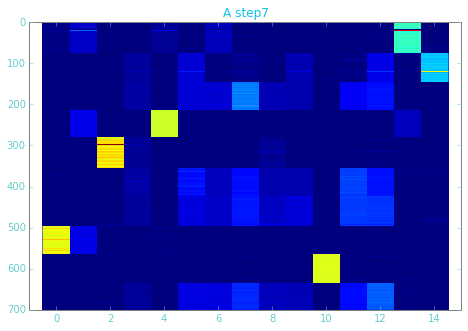

In [387]:
# Change rank, random init
data_path = os.path.join(EXPERIMENT_DIR, 'test_aug_rank15')
valid_func = lambda x, y: run_validation(data_path, x, y, sample_size=0, only_test_set=True)['p_cat_out']

A_tmp, B_tmp = recog.proximal_training(C_aug_train, PLAYLIST_GRAPH_train, SONG_GRAPH, 15,
                                       theta_tv_a=19,
                                       theta_tv_b=0,
                                       data_path=data_path,
                                       load_from_disk=False,
                                       verbose=1, validation_func=valid_func)

In [ ]:
# np.savez(data_path, A=best_A, B=best_B)

In [388]:
res = valid_func(A_tmp, B_tmp)

Validation took 26.4572169781 seconds


In [390]:
res.mean()

0.56148189741293186

### Output neighbors of a song in the song graph

In [ ]:
song_id =  SONGS[SONGS.artist_name == 'The Beatles'].index.values[0]

In [ ]:
song_id = 545685 # yesterday

In [ ]:
x = SONGS.reset_index()
song_id = 1308  # on graph

In [ ]:
def get_sorted_neighbors(query, df, g, metadata=['artist_name', 'title', 'genre'], path=None):
    s = df.reset_index()
    neighbors = g[song_id]

    res = []
    for k, v in neighbors.iteritems():
        res.append((k, v['weight']))
        
    t = list(reversed(sorted(res, key=operator.itemgetter(1))))
    sorted_neighbors = map(lambda x: x[0], t)

    res = s[s.index.isin(sorted_neighbors)][metadata]
    res = res.reindex(sorted_neighbors, copy=True).reset_index(drop=True)    
    res.index += 1
    res2 = df.iloc[query][metadata]
    
    if path is not None:
        with open(path, 'w') as f:
            f.write(res.to_latex())
            
    return res, res2

path = os.path.join(DATA_DIR, 'song_knn.tex')
neighbors, query_song = get_sorted_neighbors(song_id, SONGS, SONG_GRAPH, path=path)

In [ ]:
neighbors

In [ ]:
query_song

## Model parameters